<a href="https://colab.research.google.com/github/cpak2019/MarsPhotosDEM/blob/main/Mars_MSL_Photos_to_DEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Introduction
---

Delivables:

want to produce 10 cm resolution 100m x 100m Digital Elevation Model (DEM)
with terain labels coresponding to the DEM

format TBD

To be used as an environment for the HENA simulation



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install planetaryimage
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=1928517359b91d70c08e9fe1600ed100dc01e24a182f2b218b1297f18923f5a4
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# Downloading and loading Data
---








### Importing XYZ data from test image

In [ ]:
# defines functions used to create the adress to acess the xyz data from NASA  
import math

# following code in this block is from https://github.com/NoahAlexandroff/CMU_24789_Mars/blob/main/src/scrape_msl_depth_data.py
def msl_extract_sol(filename):
    """
    Extracts the sol from the filename for msl data
    Parameters:
    -----------
    filename: the name of the msl file that we are trying to find the sol of
    Returns:
    --------
    sol: the sol that corresponds to the provided filename
    """
    sclk = filename[4:13]
    sol = math.floor((float(sclk)-397446468.)/88775.42064)
    return sol
    
def msl_create_url(filename, prodid, extension='.IMG'):
    """
    Generates a url that can be used to download msl files from the PDS. Default values will
    return url for RNG depth data.
    Parameters:
    -----------
    filename: the name of the MSL EDR file contained in AI4Mars dataset
    prodid: the prodid of the desired url. this determines which type of data will be  
    downloaded. the default value is "RNG". more information about available prodids at
    https://pds-imaging.jpl.nasa.gov/data/msl/MSLNAV_1XXX/DOCUMENT/MSL_CAMERA_SIS.PDF
    extension: the extension to be used for the desired url. the default value is ".IMG"
    Returns:
    --------
    combined_url : the generated url that can be used to download files from the PDS
    """

    sol = msl_extract_sol(filename)
    base_url = "https://pds-imaging.jpl.nasa.gov/data/msl/MSLNAV_1XXX" 
    if sol<1870: #Changed location of data at sol 1870
        data_url = "/DATA_V1/"
    else:
        data_url = "/DATA/"
    sol_url = "SOL" + f'{sol:05d}'+"/"
    file_url = update_filename_from_edr(filename, prodid = prodid, extension=extension)
    combined_url = base_url + data_url + sol_url + file_url
    
    return combined_url

def update_filename_from_edr(edr_filename, prodid, extension):
    """
    Generates an updated filename from an edr filename for msl files from the PDS.
    Parameters:
    -----------
    edr_filename: the name of the MSL EDR file contained in AI4Mars dataset
    prodid: the prodid of the desired url. this determines which type of data will be  
    downloaded. more information about available prodids is available at
    https://pds-imaging.jpl.nasa.gov/data/msl/MSLNAV_1XXX/DOCUMENT/MSL_CAMERA_SIS.PDF
    extension: the extension to be used for the desired url
    Returns:
    --------
    updated_filename : the updated filename that incorporates the desired prodid and
    extension
    """
    updated_filename = edr_filename[0:13] + prodid + edr_filename[16:-4] + extension

    return updated_filename


In [ ]:
import glob
import os
import wget

# loading files from drive 
# |
# v change to where you are storing the few images you want to load in (recomend just start off with 1)
path = "/content/drive/MyDrive/ColabTests/ROSEDEM/*.*"

N = 1 #number of files to load from drive

imagesToProcess = []
imagesPath = []
for file in glob.glob(path):
   controlling how many files are imported
   if 0 == N:
     print("early stop importing")
     break
   else:
     N -= 1

  # loading files 
  name = os.path.basename(file)
  imagesToProcess.append(name)
  imagesPath.append(file)
  # print(name)
  # then use funcitons defined in first block to pull images, want to change prodid from RNG to XYZ, see comment for msl_create_url for more info



NLA_411614687EDR_F0051986NCAM00224M1.png


In [ ]:
#downloading XYZ data for loaded file
testfileurl = msl_create_url(name, "XYZ") 
print(testfileurl)
file = wget.download(url = testfileurl)
print(file)

https://pds-imaging.jpl.nasa.gov/data/msl/MSLNAV_1XXX/DATA_V1/SOL00159/NLA_411614687XYZ_F0051986NCAM00224M1.IMG
NLA_411614687XYZ_F0051986NCAM00224M1.IMG


/content/drive/MyDrive/ColabTests/ROSEDEM/NLA_411614687EDR_F0051986NCAM00224M1.png


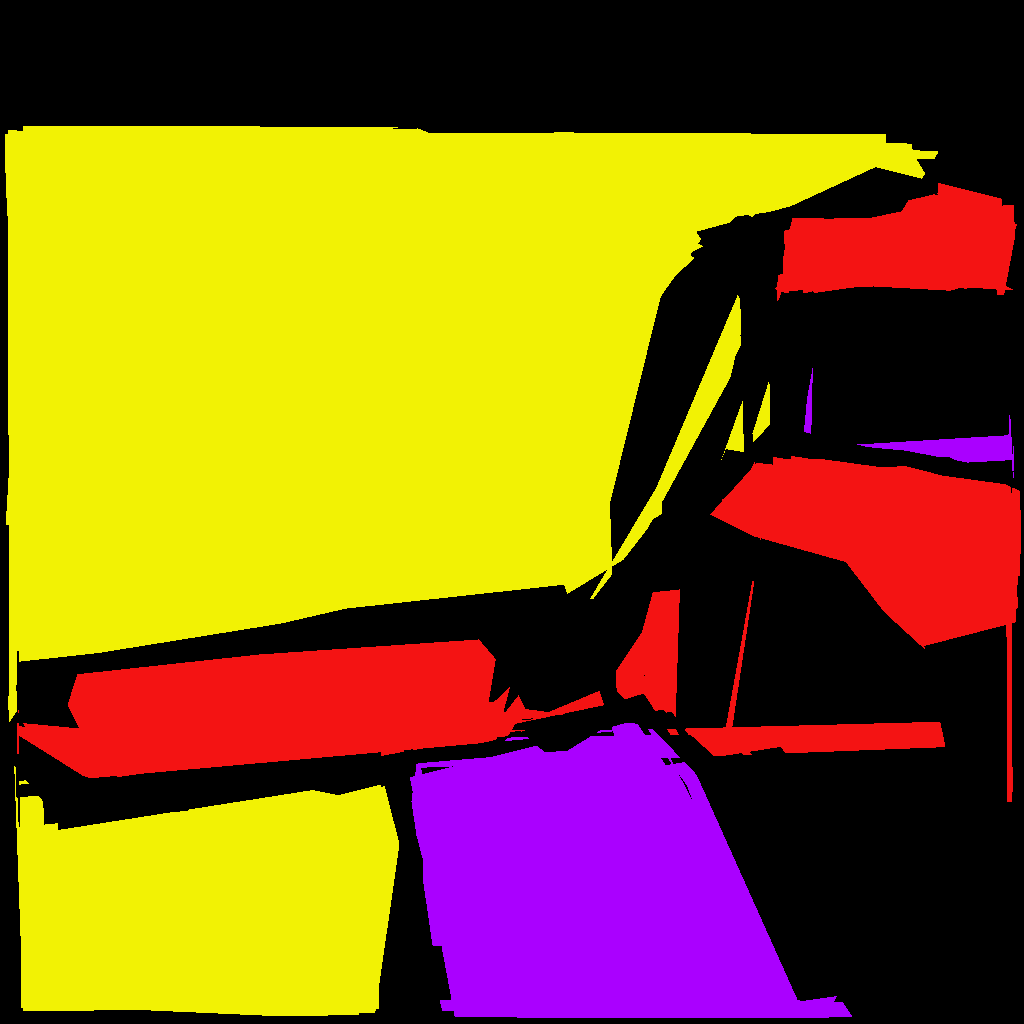

In [ ]:
# converting label colors into other colors so can see diferences in labels

import numpy as np
from PIL import Image
from planetaryimage import PDS3Image

im = Image.open(imagesPath[0], mode ='r').convert('RGB') 
print(imagesPath[0])
colorArray = np.array(im.getdata())
labelArray = np.zeros( colorArray.shape[0] )
arr2 = np.array(im)
for idx, rGB in enumerate(colorArray):
  if np.array_equal(np.array([255, 255, 255]), rGB): #no label
     colorArray[idx] = np.array([0, 0, 0])
     labelArray[idx] = -1
     continue 
  if np.array_equal(np.array([0, 0, 0]), rGB): #soil
     colorArray[idx] = np.array([76, 132, 201])
     labelArray[idx] = 1
     continue 
  if np.array_equal(np.array([1, 1, 1]), rGB): #bedrock
     colorArray[idx] = np.array([242, 242, 4])
     labelArray[idx] = 2
     continue 
  if np.array_equal(np.array([2, 2, 2]), rGB): #sand
     colorArray[idx] = np.array([170, 0, 255])
     labelArray[idx] = 3
     continue 
  if np.array_equal(np.array([3, 3, 3]), rGB): #big rock
     colorArray[idx] = np.array([244, 19, 19])
     labelArray[idx] = 4
     continue 
Image.fromarray((colorArray.reshape(1024, 1024, 3) * 1).astype(np.uint8)).convert('RGB')


In [ ]:
# reshaping the dowloaded data from (3, 1024, 1024) to (1024, 1024, 3)
img = PDS3Image.open(file)
img_arr = img.data
print(img.data.shape)
img_arr = img_arr.astype(np.float32)
img_arr = np.transpose(img_arr,(1, 2, 0))
print(img_arr.shape)
print()



(3, 1024, 1024)
(1024, 1024, 3)



### plotting XYZ data

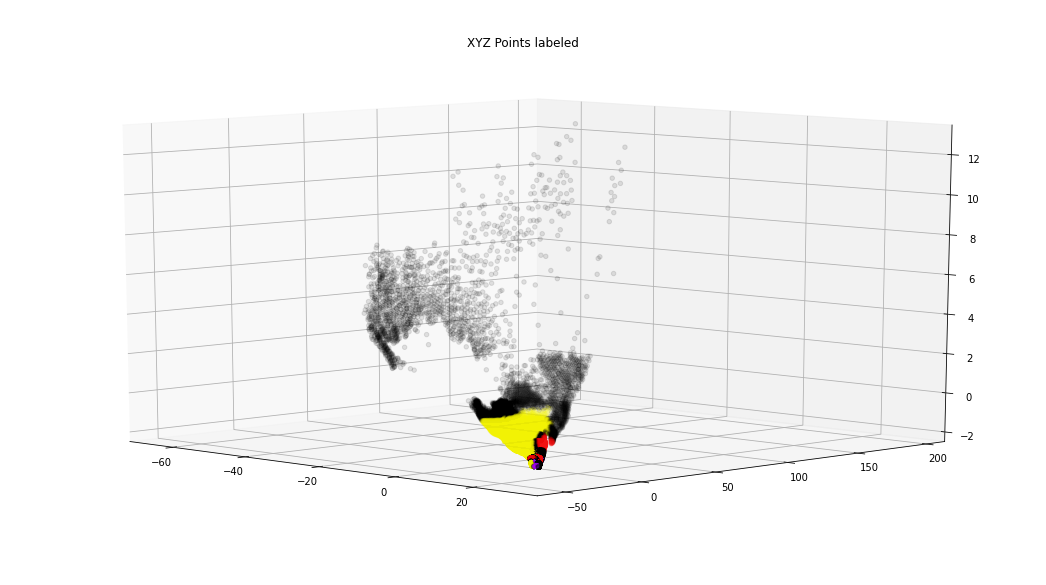

In [ ]:
#plotting the downloaded XYZ data with colors matching labels
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plotarr = img_arr.reshape(1048576, 3)[::10]
plotlabel = colorArray[::10]

# followed: https://chris35wills.github.io/courses/PythonPackages_matplotlib/matplotlib_3d/
x=plotarr[:,0]
y=plotarr[:,1]
z=plotarr[:,2]
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, -y, -z, c = plotlabel/255, alpha=.1)
ax.set_title("XYZ Points labeled")
plt.autoscale() 
# plt.show()
ax.view_init(10, -45)
plt.draw()



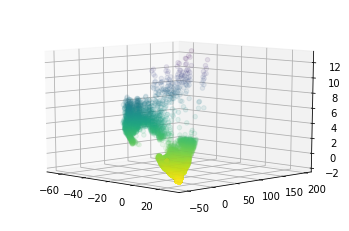

In [ ]:
# plotting xyz data with color coresponding to the elevation
plt.clf
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(x, -y, -z, c = z*100, alpha=.1)
plt.autoscale() 
ax2.view_init(10, -45)
plt.draw()

# Converting to DEM
---

ToDO

1. have labels as probability map based on neares neighbors
2. when loading in data points, also have range data so can ignore points that are a certain distance away from the rover or associate a confidence score with them and rely more on points that are closer 
3. store multiple parent points for the gaps and interpolate between them 
DEM created by NASA has 3 bands, 1 height, 2 for interpolaiton, 3 for distance from nearest parent
3. make off set work
4. site frame (make sure conventions are noted)







### DEM Class definition

In [ ]:
class DEM:
  def __init__(self, dimension, resolution, offsetx, offsety):
    self.dimension = dimension
    self.resolution = resolution

    self.modelHeight = np.zeros( (dimension, dimension), dtype=float)
    self.modelLabels = np.zeros( (dimension, dimension), dtype=int)
    self.modelcolor = np.zeros( (dimension, dimension, 3), dtype=int)

    self.sqTracker = np.full( (self.dimension, self.dimension, 3), -1, dtype=int)
    self.listOfsqs = []
    self.listOfChildren = []


    h = np.zeros( (dimension, dimension, 1), dtype=float)
    self.loadedp = np.append(h, np.zeros( (dimension, dimension, 2), dtype=int), axis = 2)
      # [0] for height     
      # [1] for labels
      # [2] for number of points matched to that array index 


  def load(self, data):
    for row in data:
      for point in row:
        
        if np.array_equal(np.array([0, 0, 0]), point): 
          continue

        y = round(point[0]/self.resolution + self.dimension/2)
        x = round(point[1]/self.resolution + self.dimension/2)

        if not ( (x < self.dimension) and (x > 0) and (y < self.dimension) and (y > 0) ):
          continue
        
        #check if order of variables the x and y is right...
        self.loadedp[y][x][2] += 1
        self.loadedp[y][x][1] = point[3] #storing label
        self.loadedp[y][x][0] = -point[2] #storing height data

        if not self.loadedp[y][x][2] > 1:
          self.listOfsqs.append((y, x))


  def fill(self, range):
    self.modelHeight = np.zeros( (self.dimension, self.dimension), dtype=float)
    self.modelLabels = np.zeros( (self.dimension, self.dimension), dtype=int)
    self.modelcolor = np.zeros( (self.dimension, self.dimension, 3), dtype=int)
    self.sqTracker = np.full( (self.dimension, self.dimension, 3), -1, dtype=int)
      #[0] tracking range from parent
      #[1/2] tracking index of parent
    sq = (0, 0)
    length = len(self.listOfsqs)
    i = 0
    while i < length:
      sq = self.listOfsqs[i]
      i += 1

      self.sqTracker[sq[0]][sq[1]][0] = range 
      self.sqTracker[sq[0]][sq[1]][1] = sq[0]
      self.sqTracker[sq[0]][sq[1]][2] = sq[1]
      self.modelHeight[sq[0]][sq[1]] = self.loadedp[sq[0]][sq[1]][0]
      self.modelLabels[sq[0]][sq[1]] = self.loadedp[sq[0]][sq[1]][1]

      if range > 0:
        self.spawnChild(sq, (sq[0], sq[1]+1), range - 1)
        self.spawnChild(sq, (sq[0], sq[1]-1), range - 1)
        self.spawnChild(sq, (sq[0]+1, sq[1]), range - 1)
        self.spawnChild(sq, (sq[0]-1, sq[1]), range - 1)
      
    switch = True
    while switch:
      try:
        sq = self.listOfChildren.pop(0)
      except: 
        switch = False

      sqsRange = self.sqTracker[sq[0]][sq[1]][0] 
      if sqsRange > 0:
        # spawn in 4 directions
        self.spawnChild(sq, (sq[0], sq[1]+1), sqsRange - 1)
        self.spawnChild(sq, (sq[0], sq[1]-1), sqsRange - 1)
        self.spawnChild(sq, (sq[0]+1, sq[1]), sqsRange - 1)
        self.spawnChild(sq, (sq[0]-1, sq[1]), sqsRange - 1)
        

  def spawnChild(self, sq, nsq, range):
    # try is to ensure the new square is in range

    #^ try is not catcing negative index, is just looping around...

    if nsq[0] >= 0 and nsq[1] >= 0 and nsq[0] < self.dimension and nsq[1] < self.dimension:
      #checking if the square has been processed
      if self.sqTracker[nsq[0]][nsq[1]][0] == -1:
        #claim and seting parent's lebel and height info
        self.sqTracker[nsq[0]][nsq[1]][0] = range

        parentX = self.sqTracker[sq[0]][sq[1]][1]
        parentY = self.sqTracker[sq[0]][sq[1]][2]
        
        self.sqTracker[nsq[0]][nsq[1]][1] = parentX
        self.sqTracker[nsq[0]][nsq[1]][2] = parentY
        self.modelHeight[nsq[0]][nsq[1]] = self.loadedp[parentX][parentY][0] #parentHeight
        self.modelLabels[nsq[0]][nsq[1]] = self.loadedp[parentX][parentY][1]  #parentLabel
        self.setColors(self.loadedp[parentX][parentY][1], nsq)
        self.listOfChildren.append( nsq )



  def returnModel(self):
    return self.modelHeight 

  def setColors(self, label, point):
      if label == -1: #no label
        self.modelcolor[point] = np.array([0, 0, 0])
      if label == 1: #soil
        self.modelcolor[point] = np.array([76, 132, 201])
      if label == 2: #bedrock
        self.modelcolor[point] = np.array([242, 242, 4])
      if label == 3: #sand
        self.modelcolor[point] = np.array([170, 0, 255])
      if label == 4: #big rock
        self.modelcolor[point] = np.array([244, 19, 19])
      if label == 0: #no point data
        self.modelcolor[point] = np.array([0, 100, 100])

In [ ]:
# creating an instance and loading in part of the data
p = DEM(20, 4, 0, 0)


testXYZ = img_arr[::10, ::10]
testLabel = labelArray.reshape(1024, 1024, 1)[::10, ::10]
testArr = np.append(testXYZ, testLabel, axis = 2)
p.load(testArr)


### Verifivation Testing

In [ ]:


p.fill(0) 
for row in p.sqTracker[::,::,0]:
  for num in row:
    print("{:+}".format(num), end=" " )
  print("")
print("")

p.fill(1) 
for row in p.sqTracker[::,::,0]:
  for num in row:
    print("{:+}".format(num), end=" " )
  print("")
print("")

p.fill(2) 
for row in p.sqTracker[::,::,0]:
  for num in row:
    print("{:+}".format(num), end=" " )
  print("")
print("")



# p.fill(10) 
# # for row in p.modelLabels:
# #   for num in row:
# #     print("{:+}".format(num), end=" " )
# #   print("")
# # print("")


-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 +0 +0 +0 +0 -1 +0 +0 +0 +0 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 +0 -1 -1 +0 +0 +0 +0 +0 +0 +0 +0 -1 -1 -1 -1 -1 -1 -1 -1 
-1 +0 +0 +0 +0 +0 +0 +0 +0 +0 -1 +0 +0 -1 -1 -1 -1 -1 -1 -1 
-1 +0 +0 +0 +0 -1 -1 -1 +0 -1 -1 -1 +0 +0 -1 -1 -1 -1 -1 -1 
-1 -1 +0 +0 +0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 +0 +0 +0 +0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 +0 -1 +0 +0 +0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 +0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 +0 -1 -1 -1 -1 -1 +0 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 +0 +0 +0 -1 -1 -1 -1 +0 -1 -1 -1 -1 -1 -1 +0 -1 
-1 -1 -1 -1 +0 +0 +0 +0 -1 -1 +0 +0 +0 +0 +0 +0 -1 -1 +0 +0 
-1 -1 -1 +0 +0 -1 +0 +0 -1 -1 -1 +0 +0 +0 +0 +0 +0 +0 +0 +0 
-1 -1 -1 -1 -1 -1 +0 -1 -1 -1 +0 +0 +0 -1 -1 +0 +0 +0 +0 +0 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 +0 +0 +0 +0 +0 +0 +0 -1 +0 
-1 -1 -1 -1 -1 -1 -1 -1 

### Plotting the Digital Elevation Map

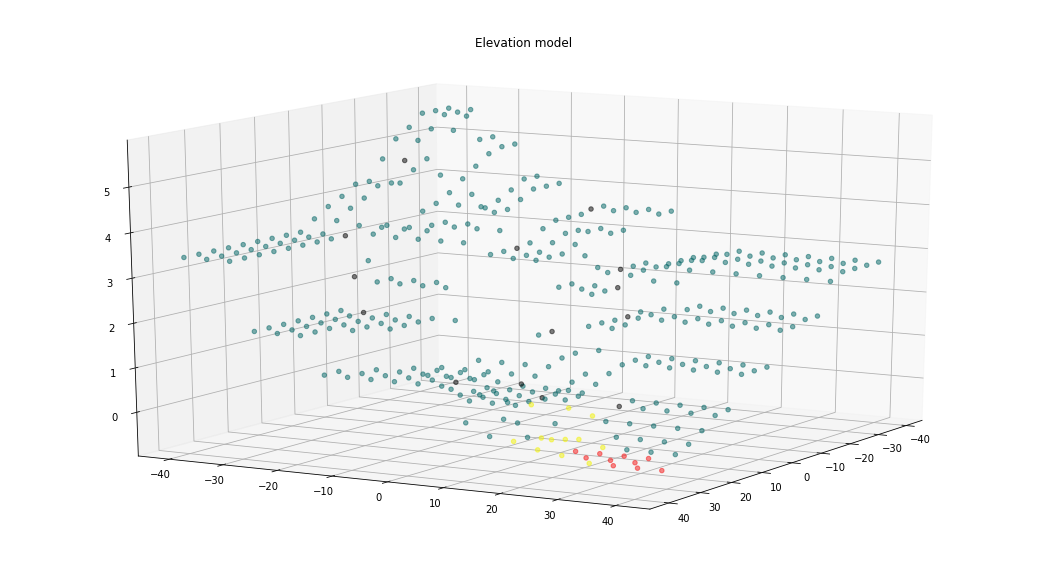

In [ ]:
p.fill(10) 

# assigning coordinates   
a = np.linspace(-p.dimension/2*p.resolution, p.dimension/2*p.resolution, p.dimension)
b = np.linspace(-p.dimension/2*p.resolution , p.dimension/2*p.resolution, p.dimension)
x, y = np.meshgrid(a, b)
z = p.modelHeight
 
# creating the visualization
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(x, y, z)
# displaying the visualization
# ax.plot_surface(x, y, z, color = p.modelcolor.reshape(p.dimension*p.dimension, 3)/255 )


ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = p.modelcolor.reshape(p.dimension*p.dimension, 3)/255, alpha=.5)


ax.set_title('Elevation model')
ax.view_init(15, 30)
plt.show()